# **Pemodelan Time Series untuk Prediksi Jumlah Penumpang Kereta Api PT. KAI untuk wilayah Jawa(Jabodetabek+Non Jabodetabek)**

## **Deployment**

https://ikbar.pythonanywhere.com/

## **Pendahuluan**

### Latar Belakang

PT Kereta Api Indonesia (PT. KAI) merupakan perusahaan transportasi nasional yang berperan penting dalam memobilisasi masyarakat dan barang di seluruh Indonesia. Untuk menghadapi tantangan operasional seperti fluktuasi jumlah penumpang yang dipengaruhi oleh faktor musiman, ekonomi, dan kebijakan pemerintah, PT. KAI perlu memanfaatkan teknologi prediksi guna meningkatkan efisiensi dan kualitas pelayanan. Proyek ini berfokus pada pemodelan time series untuk memprediksi jumlah penumpang di masa mendatang, sehingga membantu PT. KAI dalam pengambilan keputusan yang lebih tepat dan strategis.

Visi PT. KAI adalah menjadi penyedia jasa perkeretaapian terbaik yang berfokus pada layanan pelanggan, efisiensi, dan kontribusi pada ekonomi nasional. Dengan misi untuk menyediakan layanan transportasi yang aman, nyaman, dan efisien, PT. KAI mengadopsi strategi bisnis berbasis digitalisasi dan optimasi kapasitas guna meningkatkan layanan pelanggan dan mengurangi biaya operasional. Proyek prediksi ini bertujuan untuk memberikan pemahaman lebih baik terhadap pola penumpang dan mendukung pengambilan keputusan dalam hal pengoperasian kereta api.

Tujuan utama dari proyek ini adalah untuk membuat model yang memiliki akurasi tinggi dan juga dapat memprediksi jumlah penumpang yang akurat meskipun hanya memiliki beda nilai sedikit.

### Pernyataan Masalah

1. Bagaimana cara untuk membangun model yang akurat dalam memprediksi jumlah penumpang kereta api di bulan depan?

### Tujuan

Penelitian ini bertujuan untuk
melakukan peramalan penumpang Kereta
api menggunakan metode time series sehingga
dapat dilakukan penyesuaian kapasitas
layanan sesuai kebutuhan dengan harapan
dapat meningkatkan kepuasan pengguna
layanan sekaligus tingkat keuntungan dari
penyelenggara jasa layanan Kereta api.

## Pengumpulan Data

In [ ]:
#import library
import pandas as pd

# Load data
raw_df = pd.read_csv('https://raw.githubusercontent.com/IkbarIbrahim/datascience/refs/heads/main/dataKeretaApi(2006-2024).csv')
pd.options.display.float_format = '{:.0f}'.format
raw_df

,Month,PassengerCount
0,2024-08,34666
1,2024-07,36640
2,2024-06,33832
3,2024-05,33964
4,2024-04,33554
...,...,...
219,2006-05,13312
220,2006-04,12657
221,2006-03,13066
222,2006-02,11705


## Plotting Data

In [ ]:
df = raw_df[['Month', 'PassengerCount']]
df['Month'] = pd.to_datetime(df['Month'], dayfirst=True, format='%Y-%m').dt.date
df.set_index('Month', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 224 entries, 2006-01-01 to 2024-08-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   PassengerCount  224 non-null    int64
dtypes: int64(1)
memory usage: 3.5 KB


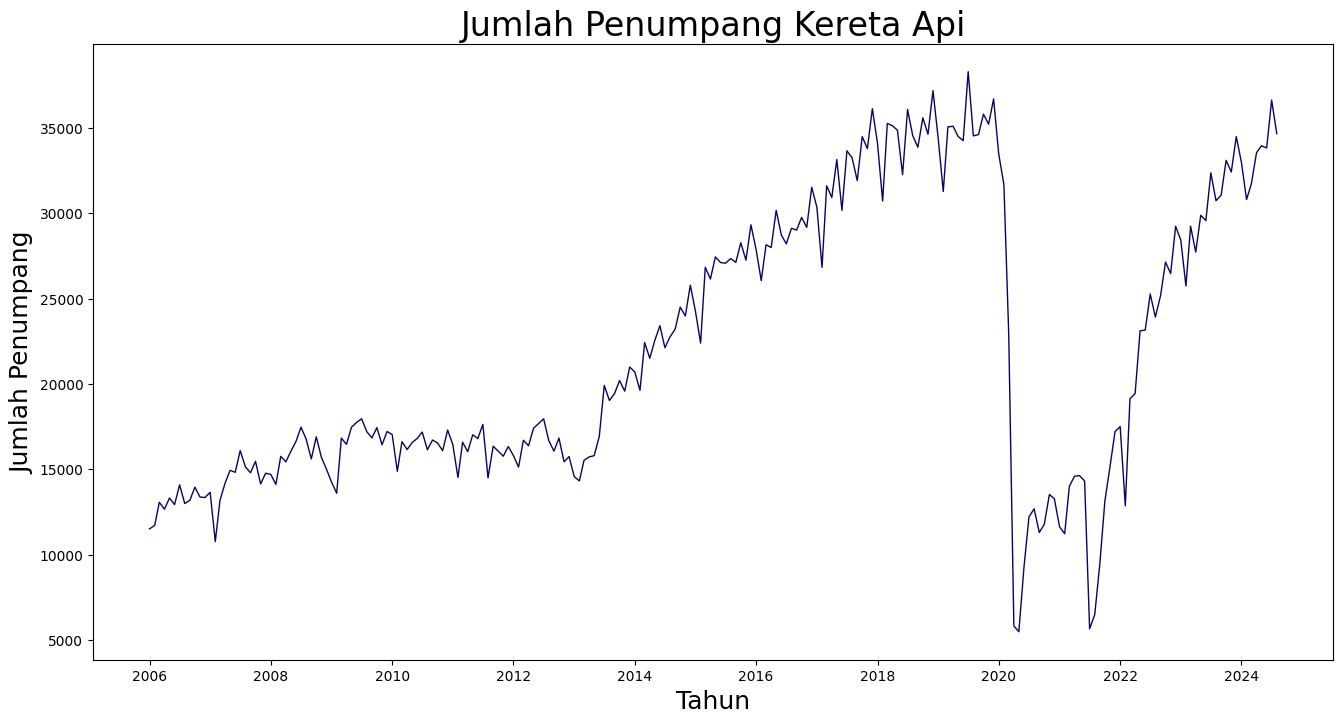

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Jumlah Penumpang Kereta Api", fontsize=24)
plt.ylabel('Jumlah Penumpang', fontsize=18)
plt.xlabel('Tahun', fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df['PassengerCount'], linewidth=1.0, dashes=False, ax=ax1)
plt.show()

## Preprocessing Data

### Normalisasi Data

In [ ]:
import numpy as np

def normalize(df):
    from sklearn.preprocessing import RobustScaler, MinMaxScaler

    np_data_unscaled = np.array(df)
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(np_data_unscaled)
    print(np_data_unscaled)
    normalized_df = pd.DataFrame(np_data_scaled, columns=df.columns, index=df.index)
    pd.set_option('display.float_format', '{:.4f}'.format)  # Menampilkan 4 desimal
    return normalized_df, scaler

# normalized_df, scaler = normalize(df)
# normalized_df

### Sliding Window

In [ ]:
def sliding_window(data, lag):
    series = data['PassengerCount']
    result = pd.DataFrame()
    for l in lag:
        result[f'xt-{l}'] = series.shift(l)

    result['xt'] = series[l:]
    result = result.dropna()
    result.index = series.index[l:]  # Mengatur index sesuai dengan nilai lag
    return result

windowed_data = sliding_window(df, [1, 2, 3])
windowed_data = windowed_data[['xt', 'xt-1', 'xt-2', 'xt-3']]
windowed_data

              xt  xt-1  xt-2  xt-3
Month                             
2006-04-01 12657 13066 11705 11504
2006-05-01 13312 12657 13066 11705
2006-06-01 12929 13312 12657 13066
2006-07-01 14087 12929 13312 12657
2006-08-01 12991 14087 12929 13312
...          ...   ...   ...   ...
2024-04-01 33554 31742 30810 32995
2024-05-01 33964 33554 31742 30810
2024-06-01 33832 33964 33554 31742
2024-07-01 36640 33832 33964 33554
2024-08-01 34666 36640 33832 33964

[221 rows x 4 columns]


In [ ]:
windowed_data.to_csv("windowed_data.csv", index=False)


### Splitting Data

In [ ]:
def split_data(data, target, train_size):
    split_index = int(len(data) * train_size)

    x_train = data[:split_index]
    y_train = target[:split_index]
    x_test = data[split_index:]
    y_test = target[split_index:]

    return x_train, y_train, x_test, y_test

input_df = windowed_data[['xt-1', 'xt-2', 'xt-3']]
target_df = windowed_data[['xt']]

x_train, y_train, x_test, y_test = split_data(input_df, target_df, 0.8)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (176, 3)
y_train shape: (176, 1)
X_test shape: (45, 3)
y_test shape: (45, 1)


## Modelling

### Regresi Linear tanpa Ensemble Bagging

#### Rumus Regresi Linear

Regresi linear dapat dinyatakan dengan rumus:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n + \epsilon
$$

di mana:
- $y$ adalah variabel dependen (target).
- $\beta_0$ adalah intercept (konstanta).
- $\beta_1, \beta_2, \ldots, \beta_n$ adalah koefisien regresi untuk masing-masing variabel independen $x_1, x_2, \ldots, x_n$.
- $\epsilon$ adalah error atau residual.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

LinearRegression()

### Metrik Evaluasi Model

#### 1. MSE (Mean Squared Error)
- *Definisi*: MSE adalah rata-rata dari kuadrat selisih antara nilai yang diprediksi dan nilai aktual.
- *Rumus*:
  $$
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  $$
  Di mana $y_i$ adalah nilai aktual, $\hat{y}_i$ adalah nilai prediksi, dan $n$ adalah jumlah data.

#### 2. RMSE (Root Mean Squared Error)
- *Definisi*: RMSE adalah akar kuadrat dari MSE, yang mengembalikan satuan ke skala yang sama dengan data asli.
- *Rumus*:
  $$
  \text{RMSE} = \sqrt{\text{MSE}}
  $$

#### 3. MAPE (Mean Absolute Percentage Error)
- *Definisi*: MAPE mengukur kesalahan dalam prediksi sebagai persentase dari nilai aktual.
- *Rumus*:
  $$
  \text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100\%
  $$

In [ ]:
# Melakukan prediksi
y_pred = linear_model.predict(x_test)

# Menghitung error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape, " %")

Mean Squared Error (MSE): 6261135.711240153
Root Mean Squared Error (RMSE): 2502.226151098288
Mean Absolute Percentage Error (MAPE): 0.11458394589243626  %


In [ ]:
# Membuat grafik perbandingan
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Regresi Linear')
plt.xlabel('Tanggal')
plt.ylabel('Harga Sell')
plt.grid()
plt.show()

ValueError: non-broadcastable output operand with shape (45,1) doesn't match the broadcast shape (45,3)

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Mendapatkan nilai prediksi dari model linear
last_row = windowed_data.iloc[-1][['xt-1', 'xt-2', 'xt-3']].values.reshape(1, -1)
predicted_value_normalized = linear_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

# Mendapatkan jumlah penumpang bulan ini
last_passenger_count = scaler.inverse_transform(normalized_df[['PassengerCount']].iloc[-1].values.reshape(-1, 1))

# Menghitung persentase perubahan
percentage_change = ((predicted_value[0][0] - last_passenger_count[0][0]) / last_passenger_count[0][0]) * 100

# Menentukan tanda positif atau negatif untuk perubahan
change_sign = '+' if percentage_change > 0 else ''

# Menampilkan output tanpa pemisah
print(f'Jumlah penumpang bulan ini: {int(last_passenger_count[0][0])}')
print(f'Prediksi jumlah penumpang untuk bulan esok: {int(predicted_value[0][0])} ({change_sign}{percentage_change:.2f}%)')


## Regresi Linear dengan Ensemble Bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor
base_model = LinearRegression()
bagging_model = BaggingRegressor(estimator=base_model, n_estimators=10, bootstrap=True)
bagging_model.fit(x_train, y_train)
y_pred = bagging_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape} %')

In [ ]:
# Membuat grafik perbandingan
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Regresi Linear Ensemble Bagging')
plt.xlabel('Tanggal')
plt.ylabel('Harga Sell')
plt.grid()
plt.show()

In [ ]:
last_row = windowed_data.iloc[-1][['xt-1', 'xt-2', 'xt-3']].values.reshape(1, -1)
predicted_value_normalized = bagging_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1)).round().astype(int)
last_count = scaler.inverse_transform(normalized_df[['PassengerCount']].iloc[-1].values.reshape(-1, 1)).round().astype(int)
percentage_change = ((predicted_value[0][0] - last_count[0][0]) / last_count[0][0]) * 100

if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Jumlah penumpang bulan ini: {last_count[0][0]}')
print(f'Prediksi jumlah penumpang untuk bulan depan: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')


### Grid Search

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def grid_search(input_df, target_df, splits, estimators, bootstrap, max_samples):
    best_rmse = float('inf')
    best_params = None
    i = 0
    for split in splits:
        x_train, y_train, x_test, y_test = split_data(input_df, target_df, split)
        for estimator in estimators:
            for bootstrap in bootstraps:
                for max_sample in max_samples:
                    base_model = LinearRegression()
                    bagging_model = BaggingRegressor(estimator=base_model, n_estimators=estimator, bootstrap=bootstrap, max_samples=max_sample)
                    bagging_model.fit(x_train, y_train.values.ravel())
                    y_pred = bagging_model.predict(x_test)
                    i+=1
                    current_rmse = rmse(y_test, y_pred)
                    #print(f'Model {i} split: {split}, estimator: {estimator}, bootstrap: {bootstrap}, max sample: {max_sample}, RMSE: {current_rmse}')
                    if current_rmse < best_rmse:
                        best_rmse = current_rmse
                        best_mse = mean_squared_error(y_test, y_pred)
                        best_mape = mean_absolute_percentage_error(y_test, y_pred)
                        best_model = bagging_model
                        best_params = {'estimator': estimator, 'bootstrap': bootstrap, 'train_sample': split, 'max_sample': max_sample}
                        y_test = y_test
                        y_pred = y_pred
    return best_params, best_rmse, best_mse, best_mape, best_model, y_test, y_pred

# Parameter untuk Grid Search
splits = [0.7, 0.75, 0.8, 0.85, 0.9]
estimators = [10, 20, 50, 100]
bootstraps = [True, False]
max_samples = [0.8, 0.9, 1.0]

best_params, best_rmse, best_mse, best_mape, best_model, y_test, y_pred = grid_search(input_df, target_df, splits, estimators, bootstraps, max_samples)

Dari 120 model, didapatkan model terbaik dengan parameter berikut

In [ ]:
# Parameter terbaik
print(f'Best parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')
print(f'Best MSE: {"{:.20f}".format(best_mse)}')
print(f'Best MAPE: {best_mape}')

In [ ]:
import pickle

# Menyimpan model terbaik ke file
with open('best_bagging_model.sav', 'wb') as model_file:
    pickle.dump(best_model, model_file)

print("Model terbaik berhasil disimpan sebagai 'best_bagging_model.sav'")


In [ ]:
# Membuat grafik perbandingan
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Regresi Linear Ensemble Bagging terbaik')
plt.xlabel('Tanggal')
plt.ylabel('Harga Sell')
plt.grid()
plt.show()

### Uji Coba

In [ ]:
import numpy as np
import pandas as pd

# Example data for the last three months of passenger counts
sell_1 = 34666  # Passenger count for this month
sell_2 = 36640  # Passenger count for 1 month ago
sell_3 = 33832  # Passenger count for 2 months ago

# Transforming the values using scaler (assuming scaler is predefined)
last_row = np.array([
    scaler.transform([[sell_1]]).flatten()[0],
    scaler.transform([[sell_2]]).flatten()[0],
    scaler.transform([[sell_3]]).flatten()[0]
]).reshape(1, -1)

last_row_df = pd.DataFrame(last_row, columns=['xt-1', 'xt-2', 'xt-3'])

# Predicting passenger count
predicted_value_normalized = best_model.predict(last_row_df)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

# Calculating percentage change
last_count = sell_1
percentage_change = ((predicted_value[0][0] - last_count) / last_count) * 100
change_sign = '+' if percentage_change > 0 else ''

# Output the result without any formatting
print(f'Jumlah penumpang bulan ini: {int(last_count)}')
print(f'Prediksi jumlah penumpang untuk bulan depan: {int(predicted_value[0][0])} ({change_sign}{percentage_change:.2f}%)')


## Simpan Model

In [ ]:
from sklearn.preprocessing import StandardScaler
import pickle

# Misalkan X_train adalah data fitur untuk pelatihan
scaler = StandardScaler()
scaler.fit(x_train)  # Melatih scaler hanya pada X_train

# Simpan scaler ke file
with open('scaler.sav', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Scaler berhasil disimpan sebagai 'scaler.sav'")
